# **Setting up the environment**

In [83]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math

# **Reading the csv files into dataframes**

In [2]:
# Reading the csvs into dataframes
sample = pd.read_csv('./DataSample.csv')
poi_df = pd.read_csv('./POIList.csv')

# **Exploring the datasets first**

In [3]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22025 entries, 0 to 22024
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   _ID        22025 non-null  int64  
 1    TimeSt    22025 non-null  object 
 2   Country    22025 non-null  object 
 3   Province   22025 non-null  object 
 4   City       22025 non-null  object 
 5   Latitude   22025 non-null  float64
 6   Longitude  22025 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.2+ MB


Sample observations:

- ' TimeSt' column name has a space at the start of the string.
- It seems we don't have null values in the data set.
- Latitude and Longitude columns have the right Dtype for analysis

In [4]:
poi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   POIID      4 non-null      object 
 1    Latitude  4 non-null      float64
 2   Longitude  4 non-null      float64
dtypes: float64(2), object(1)
memory usage: 224.0+ bytes


poi_df observations:

- ' Latitude' column name has a space at the start of the string.
- It seems we don't have null values in the data set.
- Latitude and Longitude columns have the right Dtype for analysis.

# **Question 1**
## **Cleaning the dataset**

For both datasets:
1. Renaming the columns first to have consistency accross the data.

2. Checking all the duplicate records in the datasets using the keep=False argument.

3. Droping the duplicates.

In [5]:
## sample dataset
sample = sample.rename(columns={' TimeSt':'TimeSt', 'Latitude':'Logs_Latitude', 'Longitude':'Logs_Longitude'})
sample.loc[sample.duplicated(subset=['TimeSt', 'Logs_Latitude', 'Logs_Longitude'], keep=False)]
cleaned_sample = sample.drop_duplicates(subset=['TimeSt', 'Logs_Latitude', 'Logs_Longitude'])

## POI dataset
poi_df = poi_df.rename(columns={' Latitude':'POI_Latitude', 'Longitude':'POI_Longitude'})
poi_df.loc[poi_df.duplicated(subset=['POI_Latitude', 'POI_Longitude'], keep=False)]
cleaned_poi = poi_df.drop_duplicates(subset=['POI_Latitude', 'POI_Longitude'])

# **Question 2**
## Labeling each record

To calculate the distance between to records and the POIs using latitude and longitude, the Haversine Equation is needed.

In [6]:
def h_distance(lat_1, lon_1, lat_2, lon_2):
    # Converting distances between latitudes and longitudes to radius
    dist_lat = (lat_2 - lat_1) * math.pi / 180.0
    dist_lon = (lon_2 - lon_1) * math.pi / 180.0
    # converting latitudes to radians for use in the formula
    lat_1 = (lat_1) * math.pi / 180.0
    lat_2 = (lat_2) * math.pi / 180.0
    # Calculating the formula
    a = (pow(math.sin(dist_lat / 2), 2) + 
            pow(math.sin(dist_lon / 2), 2) *
            math.cos(lat_1) * math.cos(lat_2))
    rad = 6371
    c = 2 * math.asin(math.sqrt(a))
    km_dist = rad * c 

    return km_dist

Next, the nearest function is defined. This function will return each POI with the lowest distance for each record in the sample dataset. 

In [7]:
# For each POI record in the cleaned POI dataset, the nearest function will
# calculate the distance between those records and the sample records.
# Then, it will return the POIID with the lowest distance.
def nearest(lat, lon):
    distances = cleaned_poi.apply(
        lambda row: h_distance(lat, lon, row['POI_Latitude'], row['POI_Longitude']), axis=1)
    return cleaned_poi.loc[distances.idxmin()]['POIID']

The nearest function is applied and the result is stored in a variable to append it to the sample dataset. The result is each request with its closest POI assigned.

In [8]:
# Applies the nearest function to each row in the cleaned_sample dataframe
# and appends a new column with the nearest POIID to the record. 
poiid_values = cleaned_sample.apply(
    lambda row: nearest(row['Logs_Latitude'], row['Logs_Longitude']), axis=1
)
# Copying the dataframe to nor incurr in SettingWithCopyWarning
sample_copied = cleaned_sample.copy()
# Creating new column and appending POIID values.
sample_copied['POIID'] = poiid_values
sample_copied

,_ID,TimeSt,Country,Province,City,Logs_Latitude,Logs_Longitude,POIID
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,POI3
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,POI3
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,POI3
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,POI3
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730,POI3
...,...,...,...,...,...,...,...,...
22019,5614760,2017-06-21 08:23:01.793,CA,AB,Calgary,51.02093,-114.10621,POI1
22020,5614801,2017-06-21 12:23:07.880,CA,ON,Saint Catharines,43.16440,-79.24560,POI3
22022,5614909,2017-06-21 00:23:07.903,CA,ON,Whitby,43.88730,-78.94220,POI3
22023,5614912,2017-06-21 11:23:07.953,CA,ON,Oakville,43.49340,-79.71260,POI3


# **Question 3**
## Analysis

## 3.1. Mean and Std. Deviation of POIs

Merging the sample_copied dataframe with the cleaned_poi dataframe to be able to append the distances in kilometers and calculate the mean and std. deviation for each POI.  

In [9]:
merged = sample_copied.merge(cleaned_poi, how='left', on='POIID')

distance_values = merged.apply(
    lambda row: h_distance(row['Logs_Latitude'], row['Logs_Longitude'], row['POI_Latitude'], row['POI_Longitude']), axis=1
)

merged['Km_Distance'] = distance_values


grouped_df = merged.groupby(['POIID']).agg({'Km_Distance':{'mean', 'std'}})

merged

,_ID,TimeSt,Country,Province,City,Logs_Latitude,Logs_Longitude,POIID,POI_Latitude,POI_Longitude,Km_Distance
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,POI3,45.521629,-73.566024,593.413441
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,POI3,45.521629,-73.566024,677.309655
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,POI3,45.521629,-73.566024,569.647737
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,POI3,45.521629,-73.566024,634.733996
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730,POI3,45.521629,-73.566024,634.733996
...,...,...,...,...,...,...,...,...,...,...,...
19994,5614760,2017-06-21 08:23:01.793,CA,AB,Calgary,51.02093,-114.10621,POI1,53.546167,-113.485734,283.944922
19995,5614801,2017-06-21 12:23:07.880,CA,ON,Saint Catharines,43.16440,-79.24560,POI3,45.521629,-73.566024,522.019302
19996,5614909,2017-06-21 00:23:07.903,CA,ON,Whitby,43.88730,-78.94220,POI3,45.521629,-73.566024,461.995129
19997,5614912,2017-06-21 11:23:07.953,CA,ON,Oakville,43.49340,-79.71260,POI3,45.521629,-73.566024,536.874099



## 3.2. Circle, Radius and Density

In [56]:
# Creating different dataframes por each POI to detect and remove outliers
poi1_df = merged.loc[merged['POIID'] == 'POI1']
poi3_df = merged.loc[merged['POIID'] == 'POI3']
poi4_df = merged.loc[merged['POIID'] == 'POI4']

Ploting the three dataframes with each POI to determine if there are outliers.
POI1 and POI4 seem to have some outliers. 

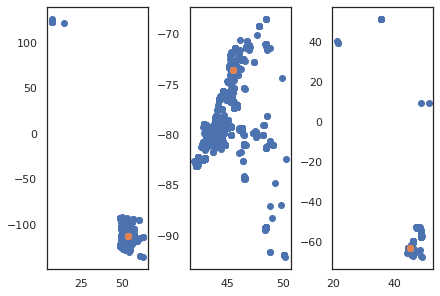

In [72]:
figure, axs = plt.subplots(1, 3, constrained_layout=True)

axs[0].scatter(x=poi1_df['Logs_Latitude'], y=poi1_df['Logs_Longitude'])
axs[0].scatter(x=poi1_df['POI_Latitude'], y=poi1_df['POI_Longitude'])

axs[1].scatter(x=poi3_df['Logs_Latitude'], y=poi3_df['Logs_Longitude'])
axs[1].scatter(x=poi3_df['POI_Latitude'], y=poi3_df['POI_Longitude'])

axs[2].scatter(x=poi4_df['Logs_Latitude'], y=poi4_df['Logs_Longitude'])
axs[2].scatter(x=poi4_df['POI_Latitude'], y=poi4_df['POI_Longitude'])

plt.show()

Removing outliers for POI1 and POI4.

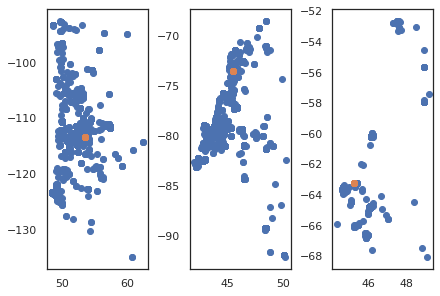

In [73]:
# Copying the dataframe to nor incurr in SettingWithCopyWarning
poi1_copied = poi1_df.copy()
# Calculating the zscore for each distance record
poi1_copied['z_score'] = stats.zscore(poi1_df['Km_Distance'])
# Removing the outliers
poi1_copied = poi1_copied.loc[poi1_copied['z_score'].abs()<=3]

# Copying the dataframe to nor incurr in SettingWithCopyWarning
poi4_copied = poi4_df.copy()
# Calculating the zscore for each distance record
poi4_copied['z_score'] = stats.zscore(poi4_df['Km_Distance'])
# Removing the outliers
poi4_copied = poi4_copied.loc[poi4_copied['z_score'].abs()<=3]

# Plotting to check if outliers were correctly removed.
figure, axs = plt.subplots(1, 3, constrained_layout=True)
axs[0].scatter(x=poi1_copied['Logs_Latitude'], y=poi1_copied['Logs_Longitude'])
axs[0].scatter(x=poi1_copied['POI_Latitude'], y=poi1_copied['POI_Longitude'])
axs[1].scatter(x=poi3_df['Logs_Latitude'], y=poi3_df['Logs_Longitude'])
axs[1].scatter(x=poi3_df['POI_Latitude'], y=poi3_df['POI_Longitude'])
axs[2].scatter(x=poi4_copied['Logs_Latitude'], y=poi4_copied['Logs_Longitude'])
axs[2].scatter(x=poi4_copied['POI_Latitude'], y=poi4_copied['POI_Longitude'])

plt.show()

Calculating Radius and Density for each POI

In [101]:
poi1_radius = poi1_copied['Km_Distance'].max()
poi1_area = pi * poi1_radius**2
poi1_density = poi1_copied['_ID'].count() / poi1_area

poi3_radius = poi3_df['Km_Distance'].max()
poi3_area = pi * poi3_radius**2
poi3_density = poi3_df['_ID'].count() / poi3_area

poi4_radius = poi4_copied['Km_Distance'].max()
poi4_area = pi * poi4_radius**2
poi4_density = poi4_copied['_ID'].count() / poi4_area

print(
    ' POI1 Radius =', poi1_radius, '|', 'POI1 Density =', poi1_density, '\n',
    'POI3 Radius =', poi3_radius, '|', 'POI3 Density =', poi3_density, '\n',
    'POI4 Radius =', poi4_radius, '|', 'POI4 Density =', poi4_density, '\n'
)

 POI1 Radius = 1514.3218390283691 | POI1 Density = 0.0013490726509560302 
 POI3 Radius = 1474.5809620285693 | POI3 Density = 0.0014338949082717462 
 POI4 Radius = 855.2562887218616 | POI4 Density = 0.00020104790427206027 

